# CLASSIFICATION MODELS

In [1]:
import os
import pandas as pd
import numpy as np
import csv
from random import randint, uniform
from datetime import datetime
from urllib import urlretrieve
from zipfile import ZipFile
import fiona 

from shapely.geometry import Point
from shapely.geometry import Polygon

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('bmh')
plt.rcParams['figure.figsize'] = (10.0, 10.0)

import re
import requests
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
from sklearn.linear_model import LinearRegression
import pickle 
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold

import warnings

In [49]:
# BRING IN INFO
stations = pd.DataFrame.from_csv('Sixth_try.csv')
stations.head()

,id,index,assemdist,atomicid,borough,censusbloc,censustrac,commdist,electdist,schooldist,...,lat,zipcodes,density,houseofunits,totalwages,wealthy,id.6,mtaid,atomicid.3,mtaindex
0,7,6,62,5024402341,5,3033,24400,503,1,31,...,40.497466,10307,7191.836735,5354,361115820.0,25618.318672,NaN,NaN,NaN,NaN
1,10,9,62,5024402337,5,3029,24400,503,1,31,...,40.498321,10307,7191.836735,5354,361115820.0,25618.318672,NaN,NaN,NaN,NaN
2,18,17,62,5024402239,5,2019,24400,503,1,31,...,40.501145,10307,7191.836735,5354,361115820.0,25618.318672,NaN,NaN,NaN,NaN
3,23,22,62,5024402227,5,2017,24400,503,1,31,...,40.501943,10307,7191.836735,5354,361115820.0,25618.318672,NaN,NaN,NaN,NaN
4,24,23,62,5024402231,5,2004,24400,503,3,31,...,40.502128,10307,7191.836735,5354,361115820.0,25618.318672,NaN,NaN,NaN,NaN


In [50]:
stations.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66135 entries, 0 to 66134
Data columns (total 66 columns):
id                   66135 non-null int64
index                66135 non-null int64
assemdist            66135 non-null int64
atomicid             66135 non-null int64
borough              66135 non-null int64
censusbloc           66135 non-null int64
censustrac           66135 non-null int64
commdist             66135 non-null int64
electdist            66135 non-null int64
schooldist           66135 non-null int64
shape_area           66135 non-null float64
shape_leng           66135 non-null float64
water_flag           66135 non-null int64
station1_distance    66135 non-null float64
station1_index       66135 non-null int64
station2_distance    66135 non-null float64
station2_index       66135 non-null int64
station3_distance    66135 non-null float64
station3_index       66135 non-null int64
stationid            736 non-null float64
year                 736 non-null float64

In [52]:
# DROP COLUMNS 
stations = stations.drop(['id', 'index','atomicid',
                          'station1_index', 'station2_index', 'station3_index', 
                          'stationid', 'total_months','as_start_count', 'as_end_count', 'as_start_avg', 'as_end_avg', 
                          'id.1', 'stationid1', 'id.2', 'stationid2', 'id.3', 'stationid3', 'id.4', 'atomicid.1', 
                         'atomicid.2', 'id.5' , 'id.6', 'mtaid', 'atomicid.3'],1)

In [53]:
stations.head()

,assemdist,borough,censusbloc,censustrac,commdist,electdist,schooldist,shape_area,shape_leng,water_flag,...,as_end_avg3,zone_type,long,lat,zipcodes,density,houseofunits,totalwages,wealthy,mtaindex
0,62,5,3033,24400,503,1,31,180710.247044,1866.886880,2,...,342.333333,NaN,-74.247175,40.497466,10307,7191.836735,5354,361115820.0,25618.318672,NaN
1,62,5,3029,24400,503,1,31,136178.817519,1588.985315,2,...,342.333333,NaN,-74.243662,40.498321,10307,7191.836735,5354,361115820.0,25618.318672,NaN
2,62,5,2019,24400,503,1,31,54085.472161,979.151858,2,...,342.333333,NaN,-74.237088,40.501145,10307,7191.836735,5354,361115820.0,25618.318672,NaN
3,62,5,2017,24400,503,1,31,40268.456034,893.308619,2,...,342.333333,NaN,-74.237964,40.501943,10307,7191.836735,5354,361115820.0,25618.318672,NaN
4,62,5,2004,24400,503,3,31,104962.697280,1391.076425,2,...,342.333333,NaN,-74.234371,40.502128,10307,7191.836735,5354,361115820.0,25618.318672,NaN


In [54]:
# CREATE DUMMY AND Y VARIABLE
def fix(y):
    if y > 0:
        return True
    else:
        return False

In [55]:
stations['MTA'] = stations.mtaindex.apply(fix)
stations =  stations.drop(['mtaindex'],1)

In [56]:
stations['y'] = stations.year.apply(fix)
stations =  stations.drop(['year'],1)

In [58]:
# CLEAN NANS
stations = stations.fillna(value='X')

In [59]:
# FILTER FOR MANHATTAN 
stations = stations[stations.borough != 5] # SI
stations = stations[stations.borough != 2] # BX
stations = stations[stations.borough != 3] # 
stations = stations[stations.borough != 4] # 

In [61]:
# SPECIFY COLUMNS 
stations.assemdist = stations.assemdist.apply(lambda x: str(x))
stations.censusbloc = stations.censusbloc.apply(lambda x: str(x))
stations.censustrac = stations.censustrac.apply(lambda x: str(x))
stations.commdist = stations.commdist.apply(lambda x: str(x))
stations.electdist = stations.electdist.apply(lambda x: str(x))
stations.schooldist = stations.schooldist.apply(lambda x: str(x))
stations.water_flag = stations.water_flag.apply(lambda x: str(x))
stations.zone_type = stations.zone_type.apply(lambda x: str(x))
stations.zipcodes = stations.zipcodes.apply(lambda x: str(x))

In [62]:
# SANITY CHECKS
stations.MTA.value_counts()

False    8291
True      261
Name: MTA, dtype: int64

In [63]:
# SANITY CHECKS
stations.y.value_counts()

False    8117
True      435
Name: y, dtype: int64

In [65]:
# CATEGORIZE VARIABLES
import patsy
from patsy import dmatrices
form = 'assemdist+censusbloc+censustrac+commdist+electdist+schooldist+water_flag+zone_type+zipcodes+MTA'
categorical = patsy.dmatrix(form, data=stations,return_type='dataframe')
categorical.head()

,Intercept,assemdist[T.65],assemdist[T.66],assemdist[T.67],assemdist[T.68],assemdist[T.69],assemdist[T.70],assemdist[T.71],assemdist[T.72],assemdist[T.73],...,zipcodes[T.10463],zipcodes[T.11102],zipcodes[T.11109],zipcodes[T.11211],zipcodes[T.11222],zipcodes[T.11231],zipcodes[T.7020],zipcodes[T.7086],zipcodes[T.7311],MTA[T.True]
2305,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2395,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3004,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3012,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3056,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [66]:
categorical.columns

Index([u'Intercept', u'assemdist[T.65]', u'assemdist[T.66]',
       u'assemdist[T.67]', u'assemdist[T.68]', u'assemdist[T.69]',
       u'assemdist[T.70]', u'assemdist[T.71]', u'assemdist[T.72]',
       u'assemdist[T.73]',
       ...
       u'zipcodes[T.10463]', u'zipcodes[T.11102]', u'zipcodes[T.11109]',
       u'zipcodes[T.11211]', u'zipcodes[T.11222]', u'zipcodes[T.11231]',
       u'zipcodes[T.7020]', u'zipcodes[T.7086]', u'zipcodes[T.7311]',
       u'MTA[T.True]'],
      dtype='object', length=777)

In [67]:
stations1 = pd.concat([stations, categorical], 1)
stations1.shape

(8552, 818)

In [68]:
# CLEAN UP
stations2 = stations1.drop(['assemdist', 'censusbloc', 'censustrac', 'commdist', 
                            'electdist' , 'schooldist', 'water_flag', 'zone_type', 'zipcodes',
                           'density','totalwages', 'wealthy', 'houseofunits',# find a way to keep these?
                           'MTA'], 1)
stations2.shape

(8552, 804)

In [70]:
# NORMALIZE
from sklearn import preprocessing
from sklearn.metrics import accuracy_score

stations3 = preprocessing.normalize(stations2, axis=0,norm='max')
stations3 = pd.DataFrame(stations3, columns=stations2.columns)
stations.describe()

,borough,shape_area,shape_leng,station1_distance,station2_distance,station3_distance,year1,total_months1,as_start_count1,as_end_count1,...,as_end_avg2,year3,total_months3,as_start_count3,as_end_count3,as_start_avg3,as_end_avg3,long,lat,houseofunits
count,8552.0,8.552000e+03,8552.000000,8.552000e+03,8552.000000,8552.000000,8552.000000,8552.000000,8552.000000,8552.000000,...,8552.000000,8552.000000,8552.000000,8552.000000,8552.000000,8552.000000,8552.000000,8552.000000,8552.000000,8552.000000
mean,1.0,1.135428e+05,1301.292546,1.116485e-02,0.012071,0.012926,2014.592961,21.238775,56821.833138,57023.453344,...,2355.989980,2014.599041,21.109331,53140.823901,53131.380847,2005.846209,1991.721204,-73.969610,40.771405,18754.923410
std,0.0,3.742064e+05,1333.240348,1.875842e-02,0.018635,0.018763,1.404426,17.462017,63084.368282,63469.735638,...,1748.507107,1.400925,17.374206,62081.628632,62101.993258,1833.669651,1835.499001,0.028000,0.046435,12087.004129
min,1.0,2.455816e+01,24.064403,3.693828e-08,0.000003,0.000026,2013.000000,1.000000,1.000000,2.000000,...,0.500000,2013.000000,1.000000,1.000000,2.000000,0.250000,0.500000,-74.047292,40.683634,0.000000
25%,1.0,6.674455e+03,571.065047,7.492427e-04,0.001607,0.002230,2013.000000,4.000000,6925.000000,6753.000000,...,1147.487805,2013.000000,4.000000,3191.000000,2997.000000,797.750000,749.250000,-73.994012,40.730668,10211.000000
50%,1.0,3.314119e+04,1063.512916,1.799785e-03,0.002762,0.003616,2015.000000,15.000000,29253.000000,27222.000000,...,1953.731707,2015.000000,15.000000,25476.000000,24756.000000,1698.400000,1661.634146,-73.971938,40.766835,16506.000000
75%,1.0,1.269684e+05,1629.306569,1.465174e-02,0.015403,0.017085,2016.000000,41.000000,93743.000000,95654.000000,...,3215.804878,2016.000000,41.000000,87565.000000,89139.000000,2771.365854,2761.512195,-73.944417,40.805094,30368.000000
max,1.0,1.197165e+07,24190.716058,9.019626e-02,0.090850,0.091145,2016.000000,41.000000,397813.000000,359122.000000,...,24874.600000,2016.000000,41.000000,397813.000000,359122.000000,23966.000000,24874.600000,-73.906928,40.878888,47617.000000


In [71]:
stations3.shape

(8552, 804)

# MODELS

In [ ]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

In [73]:
# SPLIT DATA

X = stations3.drop(['y'],1)
Y = stations3['y']

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=.30)

### KNN

KNN (n=1) accuracy: 0.9174
KNN (n=2) accuracy: 0.9439
KNN (n=3) accuracy: 0.9369
KNN (n=4) accuracy: 0.9431
KNN (n=5) accuracy: 0.9400
KNN (n=6) accuracy: 0.9427
KNN (n=7) accuracy: 0.9415
KNN (n=8) accuracy: 0.9423
KNN (n=9) accuracy: 0.9419
KNN (n=10) accuracy: 0.9423
KNN (n=11) accuracy: 0.9435
KNN (n=12) accuracy: 0.9431
KNN (n=13) accuracy: 0.9431
KNN (n=14) accuracy: 0.9427
KNN (n=15) accuracy: 0.9431
KNN (n=16) accuracy: 0.9427
KNN (n=17) accuracy: 0.9431
KNN (n=18) accuracy: 0.9427
KNN (n=19) accuracy: 0.9427
KNN max accuracy: 0.9439


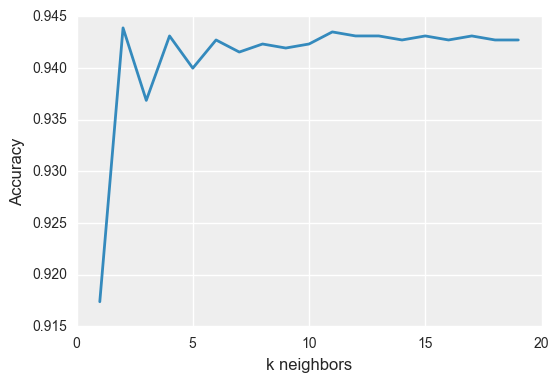

In [74]:
accs = []
for n in range(1,20):
    modelKN = KNeighborsClassifier(n_neighbors=n).fit(X_train,Y_train)
    Y_test_pred = modelKN.predict(X_test)
    accuracy = accuracy_score(Y_test, Y_test_pred)
    accs.append(accuracy)
    print 'KNN (n=%i) accuracy: %.4f' % (n,accuracy)

print 'KNN max accuracy: %.4f' % max(accs)
plt.plot(range(1,20), accs)
plt.xlabel('k neighbors')
plt.ylabel('Accuracy')

### LOGISTIC REGRESSION

In [75]:
from sklearn.linear_model import LogisticRegression

modelLR = LogisticRegression().fit(X_train, Y_train)
Y_test_pred = modelLR.predict(X_test)
logit_accuracy = accuracy_score(Y_test, Y_test_pred)
print 'Logistic Regression accuracy: %.4f' % logit_accuracy

Logistic Regression accuracy: 0.9439


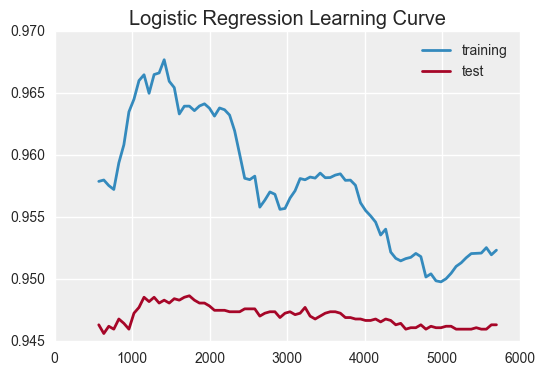

In [76]:
from sklearn.learning_curve import learning_curve

m,train_err,ts_err = learning_curve(LogisticRegression(),
                                    X,
                                    Y, 
                                    train_sizes=np.linspace(0.1, 1.0, 80))

train_cv_err = np.mean(train_err,axis=1)
test_cv_err = np.mean(ts_err,axis=1)
 
tr, = plt.plot(m,train_cv_err)
ts, = plt.plot(m,test_cv_err)
plt.legend((tr,ts),('training','test'),loc='best')
plt.title('Logistic Regression Learning Curve')


### NAIVE BAYES

In [77]:
from sklearn.naive_bayes import GaussianNB

modelGNB = GaussianNB().fit(X_train, Y_train)
Y_test_pred = modelGNB.predict(X_test)
print 'Naive Bayes (Gaussian) accuracy: %.4f' % accuracy_score(Y_test, Y_test_pred)

Naive Bayes (Gaussian) accuracy: 0.6719


### SVC

In [78]:
from sklearn.svm import SVC
modelSVC = SVC().fit(X_train, Y_train)
Y_test_pred = modelSVC.predict(X_test)
print 'SVM Classifier accuracy: %.4f' % accuracy_score(Y_test, Y_test_pred)

SVM Classifier accuracy: 0.9427


### DECISION TREE

In [79]:
from sklearn.tree import DecisionTreeClassifier
modelT = DecisionTreeClassifier().fit(X_train, Y_train)
Y_test_pred = modelT.predict(X_test)
print 'Decision Tree accuracy: %.4f' % accuracy_score(Y_test, Y_test_pred)

Decision Tree accuracy: 0.9295


### RANDOM FOREST

In [80]:
from sklearn.ensemble import RandomForestClassifier
modelRF = RandomForestClassifier().fit(X_train, Y_train)
Y_test_pred = modelRF.predict(X_test)
print 'Random Forest accuracy: %.4f' % accuracy_score(Y_test, Y_test_pred)

Random Forest accuracy: 0.9454


In [81]:
# IMPORTANT FEATURES
features = zip(X.columns, modelRF.feature_importances_)
sorted(features, key=lambda x: x[1])

[('borough', 0.0),
 ('Intercept', 0.0),
 ('assemdist[T.72]', 0.0),
 ('censusbloc[T.1017]', 0.0),
 ('censusbloc[T.1019]', 0.0),
 ('censusbloc[T.1020]', 0.0),
 ('censusbloc[T.1021]', 0.0),
 ('censusbloc[T.1023]', 0.0),
 ('censusbloc[T.1025]', 0.0),
 ('censusbloc[T.1026]', 0.0),
 ('censusbloc[T.1027]', 0.0),
 ('censusbloc[T.1028]', 0.0),
 ('censusbloc[T.1029]', 0.0),
 ('censusbloc[T.1031]', 0.0),
 ('censusbloc[T.1033]', 0.0),
 ('censusbloc[T.1035]', 0.0),
 ('censusbloc[T.1037]', 0.0),
 ('censusbloc[T.1038]', 0.0),
 ('censusbloc[T.1039]', 0.0),
 ('censusbloc[T.1040]', 0.0),
 ('censusbloc[T.1041]', 0.0),
 ('censusbloc[T.1043]', 0.0),
 ('censusbloc[T.1044]', 0.0),
 ('censusbloc[T.1045]', 0.0),
 ('censusbloc[T.1046]', 0.0),
 ('censusbloc[T.1047]', 0.0),
 ('censusbloc[T.1048]', 0.0),
 ('censusbloc[T.1049]', 0.0),
 ('censusbloc[T.1050]', 0.0),
 ('censusbloc[T.1051]', 0.0),
 ('censusbloc[T.1053]', 0.0),
 ('censusbloc[T.1055]', 0.0),
 ('censusbloc[T.1997]', 0.0),
 ('censusbloc[T.1999]', 0.0),
 ('

### ALL TOGETHER

In [82]:
from sklearn.cross_validation import cross_val_score

names, accs = [],[]
for algorithm in (LogisticRegression, 
                  KNeighborsClassifier,
                  GaussianNB,
                  SVC,
                  DecisionTreeClassifier,
                  RandomForestClassifier):

    accuracy = np.mean(cross_val_score(algorithm(), X,Y, cv=10)) #10-fold cross validation
    print '%-30s %.4f' % (algorithm.__name__, accuracy)
    names.append(algorithm.__name__)
    accs.append(accuracy)

LogisticRegression             0.9466
KNeighborsClassifier           0.9421
GaussianNB                     0.6051
SVC                            0.9491
DecisionTreeClassifier         0.9270
RandomForestClassifier         0.9490


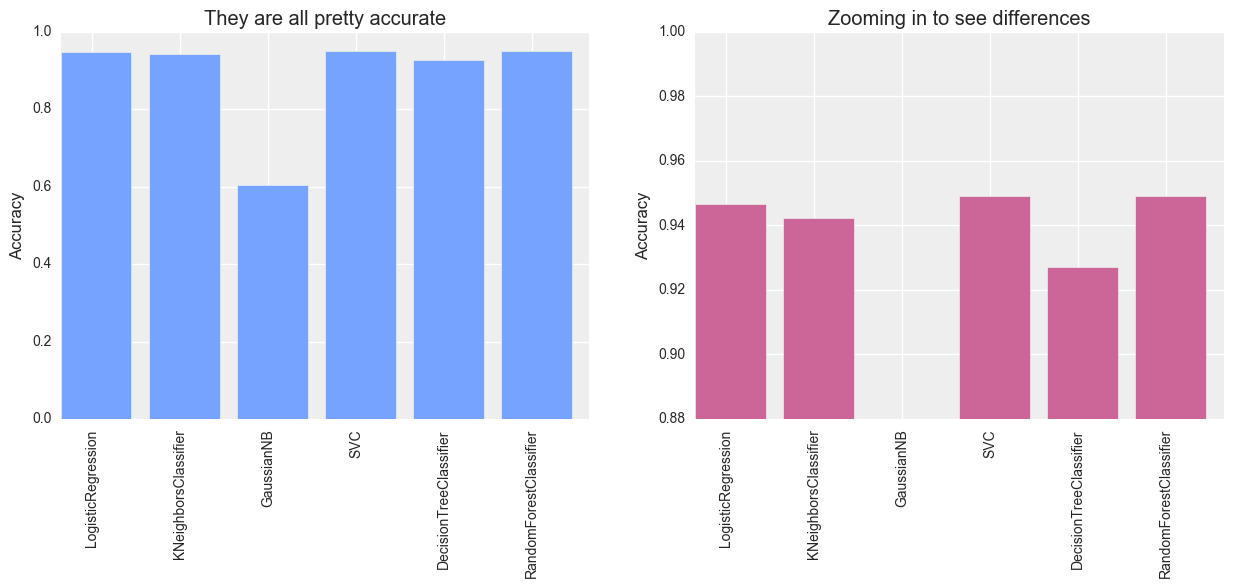

In [83]:
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.bar(range(6), accs, color='#75A3FF')
plt.xticks(np.arange(6)+0.35, names, rotation=90)
plt.ylabel("Accuracy")
plt.title('They are all pretty accurate')

plt.subplot(122)
plt.bar(range(6), accs, color='#CC6699')
plt.xticks(np.arange(6)+0.35, names, rotation=90)
plt.ylim(0.88, 1.0)
plt.ylabel("Accuracy")
plt.title('Zooming in to see differences')

In [84]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.cross_validation import cross_val_score
    
y_obs = Y_test

accuracy_dict = dict()
precision_dict = dict()
recall_dict = dict()
f1_dict = dict()
 
for algorithm in [KNeighborsClassifier(n_neighbors=10),
            LogisticRegression(C=0.001), 
            SVC(),  
            GaussianNB(), 
            DecisionTreeClassifier(), 
            RandomForestClassifier()]:
     
    algorithm.fit(X_train, Y_train)
    y_pred = algorithm.predict(X_test)
    alg_label = str(algorithm)
    alg_label = alg_label[:alg_label.index('(')]
    
    # create dictionary of stats
    accuracy_dict[alg_label] = accuracy_score(y_obs, y_pred)
    precision_dict[alg_label] = precision_score(y_obs, y_pred)
    recall_dict[alg_label] = recall_score(y_obs, y_pred)
    f1_dict[alg_label] = f1_score(y_obs, y_pred)

    print '\n'
    print alg_label
    print '-'*20
    print
    print "classification report"
    print classification_report(y_obs, y_pred)
    print
    print '   accuracy score             %.4f ' % (accuracy_score(y_obs, y_pred))
    print '   precision score            %.4f ' % precision_score(y_obs, y_pred)
    print '   recall score               %.4f ' % recall_score(y_obs, y_pred)
    print '   f1 score                   %.4f ' % f1_score(y_obs, y_pred)
    
    

    
def print_items(dictionary):
    for k,v in dictionary.iteritems():
        spaces = 30-len(k)
        newclf = k + ' '*spaces
        print '  %s %.4f' % (newclf, v)
        

print '\nPresent by Statistics to Compare Models'

print '\nAccuracy'
print_items(accuracy_dict)

print '\nPrecision'
print_items(precision_dict)

print '\nRecall'
print_items(recall_dict)

print '\nF1'
print_items(f1_dict)



KNeighborsClassifier
--------------------

classification report
             precision    recall  f1-score   support

        0.0       0.94      1.00      0.97      2419
        1.0       0.33      0.01      0.01       147

avg / total       0.91      0.94      0.92      2566


   accuracy score             0.9423 
   precision score            0.3333 
   recall score               0.0068 
   f1 score                   0.0133 


LogisticRegression
--------------------

classification report
             precision    recall  f1-score   support

        0.0       0.94      1.00      0.97      2419
        1.0       0.00      0.00      0.00       147

avg / total       0.89      0.94      0.91      2566


   accuracy score             0.9427 
   precision score            0.0000 
   recall score               0.0000 
   f1 score                   0.0000 


SVC
--------------------

classification report
             precision    recall  f1-score   support

        0.0       0.94      

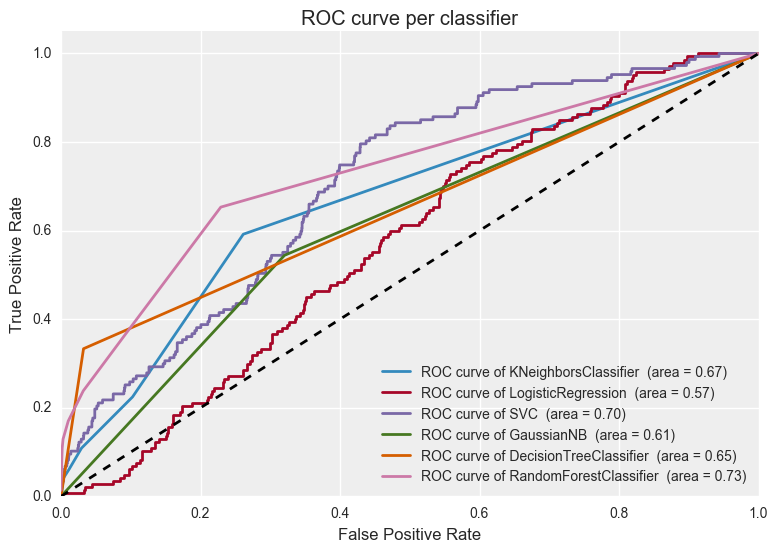

In [85]:
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import roc_curve, auc

fig = plt.figure()
fig.set_figheight(6)
fig.set_figwidth(9)
plt.subplot(1,1,1)

for i, alg in enumerate([
            KNeighborsClassifier(n_neighbors=10), 
            LogisticRegression(C=0.001), 
            SVC(),  
            GaussianNB(), 
            DecisionTreeClassifier(), 
            RandomForestClassifier()]):
    alg.fit(X_train, Y_train)
    y_pred = alg.predict(X_test)

    try:
        y_score = alg.fit(X_train, Y_train).decision_function(X_test)
    except:
        y_score = (alg.fit(X_train, Y_train).predict_proba(X_test))[:,1]

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr[i], tpr[i], _ = roc_curve(y_obs, y_score)
    roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve
    alg_label = str(alg)
    alg_label = alg_label[:alg_label.index('(')]
    plt.plot(fpr[i], tpr[i], label='ROC curve of ' + alg_label+ '  (area = {1:0.2f})'.format(alg_label, roc_auc[i]))


plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve per classifier')
plt.legend(loc="lower right")

In [ ]:
# precision and recall!!!